In [1]:
import numpy as np
import numpy.linalg as la
import numpy.matlib as mat
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import sys

C:\Users\grace\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Jester Data

The jester dataset contains an m = 100 by n = 7200 dimensional matrix X. Each row of X corresponds to a joke, and each column corresponds to a user. Each of the users rated the quality of each joke on a scale of [-10, 10].

## a) using only the first 20 users

Suppose that you work for a company that makes joke recommendations to customers. You are given a large dataset X of jokes and ratings. It contains p reviews for each joke. The reviews were generated by p users who represent a diverse set of tastes. Each reviewer rated every joke on a scale of [-10, 10]. A new customer has rated n = 25 of the jokes, and the goal is to predict another joke that the customer will like based on her n ratings. Use the first p = 20 columns of X for this prediction problem (so that the problem is over-determined). *Specifically, we will think of the new customer's ratings as a weighted sum of the other p = 20 customers' ratings, and we will use the n = 25 joke ratings by these p = 20 customers plus the n = 25 joke ratings by the new customer to learn the weights.* The new customer's ratings are contained in the file newuser.mat, in a vector b. The jokes she didn't rate are indicated by a (false) score of -99. Compare your predictions to her complete set of ratings, contained in the vector truey. Her actual favorite joke was number 29. Does it seem like your predictor is working well? 

In [318]:
d_jest = sio.loadmat('jesterdata.mat')
X = d_jest['X']

d_new = sio.loadmat('newuser.mat')
y = d_new['y']
true_y = d_new['truey']

m,n = X.shape

train_indices = np.squeeze(y!=-99)
num_train = np.count_nonzero(train_indices)

test_indices = np.logical_not(train_indices)
num_test = m - num_train

X_data = X[train_indices, 0:20]
y_data = y[train_indices]
y_test = true_y[test_indices]

In [144]:
### train on ratings we know
w = la.inv(X_data.T@X_data)@X_data.T@y_data
y_hat_train = X_data@w
avgerr_train = ((y_data - y_hat_train)**2).mean()

### test on ratings we don't know
y_hat_test = X[test_indices,:20]@w
avgerr_test = ((y_test - y_hat_test)**2).mean()
print("predicting rating of actual favorite joke:",pd.DataFrame(y_hat_test).loc[29].values)

predicting rating of actual favorite joke: [3.36950253]


Average 1_2 error (train): 2.9540264770012317
Average 1_2 (test): 28.750050107926466


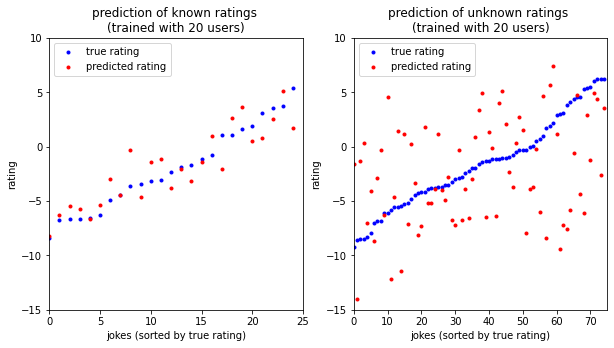

In [145]:
plt.figure(figsize=[10,5])
### performance on training jokes
ax1 = plt.subplot(121)
sorted_indices = np.argsort(np.squeeze(y_data))
ax1.plot(
    range(num_train), y_data[sorted_indices], 'b.',
    range(num_train), y_hat_train[sorted_indices], 'r.'
)
ax1.set_title('prediction of known ratings \n(trained with 20 users)')
ax1.set_xlabel('jokes (sorted by true rating)')
ax1.set_ylabel('rating')
ax1.legend(['true rating','predicted rating'], loc='upper left')
ax1.axis([0, num_train, -15,10])

print("Average 1_2 error (train):",avgerr_train)

### performance on unrated jokes
ax2 = plt.subplot(122)
sorted_indices = np.argsort(np.squeeze(y_test))
ax2.plot(
    range(num_test), y_test[sorted_indices], 'b.',
    range(num_test), y_hat_test[sorted_indices], 'r.'
)
ax2.set_title('prediction of unknown ratings \n(trained with 20 users)')
ax2.set_xlabel('jokes (sorted by true rating)')
ax2.set_ylabel('rating')
ax2.legend(['true rating','predicted rating'], loc='upper left')
ax2.axis([0, num_test, -15, 10])

print("Average 1_2 (test):", avgerr_test)

plt.show()

## b) using all the data

Repeat the prediction problem above, but this time use the entire jX matrix. Note that now the problem is under-determined. Explain how you will solve this prediction problem and apply it to the data. Does it seem like your predictor is working? How does it compare to the first method based on only 20 users?

In [8]:
def prep_svd(x, determined = 'over', pinv = False):
    svd = la.svd(x)
    U, eigvals, Vt = svd
    V = Vt.T
    SIG = np.zeros((X.shape[0],X.shape[1]))
    np.fill_diagonal(SIG, eigvals)
    if pinv:
        SIG = la.pinv(SIG)
    if not pinv:
        if determined == 'under':
            SIG = np.vstack([SIG, np.zeros((V.shape[0]-U.shape[0],U.shape[0]))])
        elif determined == 'over':
            SIG = np.hstack([SIG, np.zeros((V.shape[0],U.shape[0]-V.shape[0]))])
    return U, SIG, V
def trunc_k(U,SIG,V,k):
    U_k = np.vstack(U[:,0:k])
    SIG_k = np.vstack(SIG[0:k,0:k])
    V_k = np.vstack(V[:,0:k])
    return U_k,SIG_k,V_k
def get_w_hat(U,SIG,V,y, pinv = False):
    if pinv:
        return V@SIG@U.T@y
    else:
        return U@SIG@V.T@y
    return w_hat

In [147]:
U, SIGx, V = prep_svd(X[train_indices], pinv = True)
Uk, SIGxk, Vk = trunc_k(U, SIGx, V, la.matrix_rank(X[train_indices]))

In [148]:
w = get_w_hat(Uk,SIGxk,Vk,y[train_indices], pinv = True)

In [149]:
y_hat_train = X[train_indices]@w
avgerr_train = ((y[train_indices] - y_hat_train)**2).mean() ## *! test w the 25 jokes we have data on

y_hat_test = X[test_indices]@w
avgerr_test = ((y_test - y_hat_test)**2).mean()

In [150]:
print("predicting rating of actual favorite joke:",pd.DataFrame(y_hat_test).loc[29].values)

predicting rating of actual favorite joke: [-0.05772054]


Average 1_2 error (train): 1.1922301379638034e-28
Average 1_2 (test): 12.210523750942723


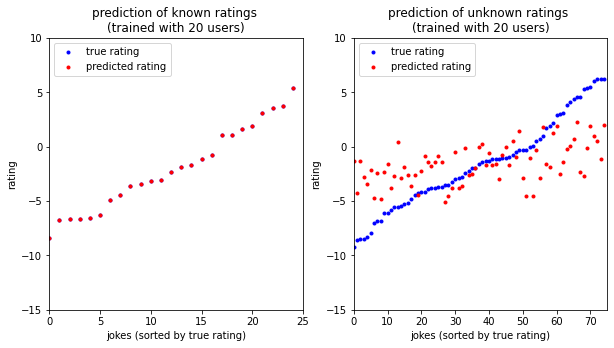

In [151]:
### performance on training jokes
plt.figure(figsize = [10,5])
ax1 = plt.subplot(121)
sorted_indices = np.argsort(np.squeeze(y_data))
ax1.plot(
    range(num_train), y_data[sorted_indices], 'b.',
    range(num_train), y_hat_train[sorted_indices], 'r.'
)
ax1.set_title('prediction of known ratings \n(trained with 20 users)')
ax1.set_xlabel('jokes (sorted by true rating)')
ax1.set_ylabel('rating')
ax1.legend(['true rating','predicted rating'], loc='upper left')
ax1.axis([0, num_train, -15,10])

print("Average 1_2 error (train):",avgerr_train)

### performance on unrated jokes
ax2 = plt.subplot(122)
sorted_indices = np.argsort(np.squeeze(y_test))
ax2.plot(
    range(num_test), y_test[sorted_indices], 'b.',
    range(num_test), y_hat_test[sorted_indices], 'r.'
)
ax2.set_title('prediction of unknown ratings \n(trained with 20 users)')
ax2.set_xlabel('jokes (sorted by true rating)')
ax2.set_ylabel('rating')
ax2.legend(['true rating','predicted rating'], loc='upper left')
ax2.axis([0, num_test, -15, 10])

print("Average 1_2 (test):", avgerr_test)

plt.show()

*The average squared error for the rated jokes is 0, and 12.21 for the unrated jokes. The predicted rating of her actual favorite was -0.06. In general, the predictions seem to overestimate the jokes she didn't like and underestimte the jokes she did.8

## c) best one user fit to new customer

Propose a method for finding one other user that seems to give the best predictions for the new user. How well does this approach perform? Now try to find the best two users to predict the new user.

*With traditional least squares, the weights are a measurement of how impactful each column is, so the best user to approximate the new user would have the largest weight based on a simple least squares regression on the rated jokes.*

In [377]:
d_jest = sio.loadmat('jesterdata.mat')
X = d_jest['X']

d_new = sio.loadmat('newuser.mat')
y = d_new['y']
true_y = d_new['truey']

m,n = X.shape

train_indices = np.squeeze(y!=-99)
num_train = np.count_nonzero(train_indices)

test_indices = np.logical_not(train_indices)
num_test = m - num_train

In [378]:
### one user (reload data)
U, SIGx, V = prep_svd(X[train_indices], pinv = True)
Uk, SIGxk, Vk = trunc_k(U, SIGx, V, la.matrix_rank(X[train_indices]))
w = get_w_hat(Uk,SIGxk,Vk,y[train_indices], pinv = True)
user1 = np.argmax(np.abs(w))
user1ratings = X[:,user1]

X = user1ratings
X_data = np.reshape(X[train_indices],(25,1))
X_test = np.reshape(X[test_indices],(75,1))
y_data = y[train_indices]
y_test = true_y[test_indices]

w1 = np.linalg.inv(X_data.T@X_data)@X_data.T@y_data

y_hat_train1 = X_data@w1
avgerr_train1 = ((y[train_indices] - y_hat_train1)**2).mean()

y_hat_test1 = X_test@w1
avgerr_test1 = ((y_test - y_hat_test1)**2).mean()

In [374]:
### two user (reload data)
w_temp = w
w_temp[user1] = 0
user2 = np.argmax(np.abs(w_temp))
user2ratings = X[:,user2]

user1ratings, user2ratings = user1ratings.reshape(100,1), user2ratings.reshape(100,1)
X = np.hstack([user1ratings,user2ratings])
X_data = np.reshape(X[train_indices],(25,2))
X_test = np.reshape(X[test_indices],(75,2))
y_data = y[train_indices]
y_test = true_y[test_indices]

w2 = np.linalg.inv(X_data.T@X_data)@X_data.T@y_data

y_hat_train2 = X_data@w2
avgerr_train2 = ((y[train_indices] - y_hat_train2)**2).mean() 

y_hat_test2 = X_test@w2
avgerr_test2 = ((y_test - y_hat_test2)**2).mean()

Average 1_2 error (train): 1.1922301379638034e-28
Average 1_2 (test): 12.210523750942723
(two user) Average 1_2 error (train): 9.421845724677608
(two user) Average 1_2 (test): 8.806834462969459


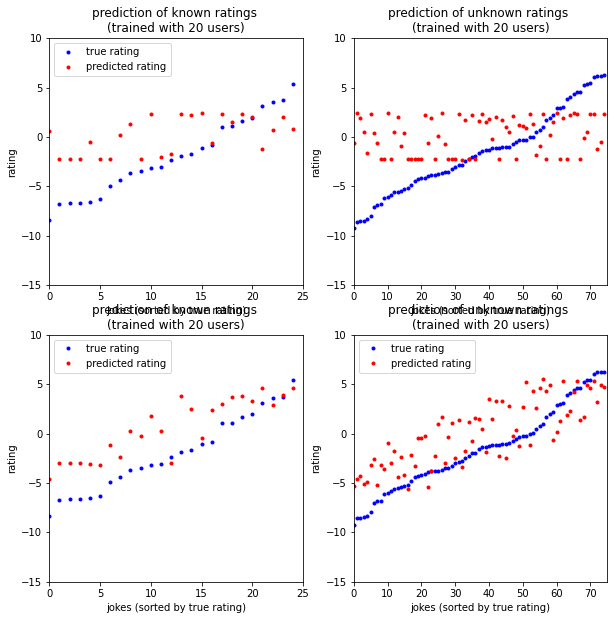

In [386]:
plt.figure(figsize=[10,10])
### one user performance on rated jokes
ax1 = plt.subplot(221)
sorted_indices = np.argsort(np.squeeze(y_data))
ax1.plot(
    range(num_train), y_data[sorted_indices], 'b.',
    range(num_train), y_hat_train1[sorted_indices], 'r.'
)
ax1.set_title('prediction of known ratings \n(trained with 20 users)')
ax1.set_xlabel('jokes (sorted by true rating)')
ax1.set_ylabel('rating')
ax1.legend(['true rating','predicted rating'], loc='upper left')
ax1.axis([0, num_train, -15,10])

print("Average 1_2 error (train):",avgerr_train)

### performance on unrated jokes
ax2 = plt.subplot(222)
sorted_indices = np.argsort(np.squeeze(y_test))
ax2.plot(
    range(num_test), y_test[sorted_indices], 'b.',
    range(num_test), y_hat_test1[sorted_indices], 'r.'
)
ax2.set_title('prediction of unknown ratings \n(trained with 20 users)')
ax2.set_xlabel('jokes (sorted by true rating)')
ax2.set_ylabel('rating')
# ax2.legend(['true rating','predicted rating'], loc='upper left')
ax2.axis([0, num_test, -15, 10])

print("Average 1_2 (test):", avgerr_test)

########### two user performance
### performance on rated jokes
ax3 = plt.subplot(223)
sorted_indices = np.argsort(np.squeeze(y_data))
ax3.plot(
    range(num_train), y_data[sorted_indices], 'b.',
    range(num_train), y_hat_train2[sorted_indices], 'r.'
)
ax3.set_title('prediction of known ratings \n(trained with 20 users)')
ax3.set_xlabel('jokes (sorted by true rating)')
ax3.set_ylabel('rating')
ax3.legend(['true rating','predicted rating'], loc='upper left')
ax3.axis([0, num_train, -15,10])

print("(two user) Average 1_2 error (train):",avgerr_train2)

### performance on unrated jokes
ax4 = plt.subplot(224)
sorted_indices = np.argsort(np.squeeze(y_test))
ax4.plot(
    range(num_test), y_test[sorted_indices], 'b.',
    range(num_test), y_hat_test2[sorted_indices], 'r.'
)
ax4.set_title('prediction of unknown ratings \n(trained with 20 users)')
ax4.set_xlabel('jokes (sorted by true rating)')
ax4.set_ylabel('rating')
ax4.legend(['true rating','predicted rating'], loc='upper left')
ax4.axis([0, num_test, -15, 10])

print("(two user) Average 1_2 (test):", avgerr_test2)

plt.show()

In [185]:
X[train_indices,0].reshape(1,-1).shape

(1, 25)

*The one user approximation has a test error of 12.21 with unevenly distributed residuals. The two user approximation performs better, with a test error of 8.81, with more evenly distributed residuals.*

## d) spectrum of X

Use the Python function numpy.linalg.svd with the full_matrices option set to 'false' to compute the SVD of X. Plot the spectrum of X. What is the rank of X? How many dimensions seem important? What does this tell us about the jokes and users?

In [197]:
la.matrix_rank(X)

100

In [190]:
svd = la.svd(X, full_matrices = False)
U, eigvals, Vt = svd
V = Vt.T
SIG = np.diag(eigvals)
SIG = np.vstack([SIG, np.zeros((V.shape[0]-U.shape[0],U.shape[0]))])

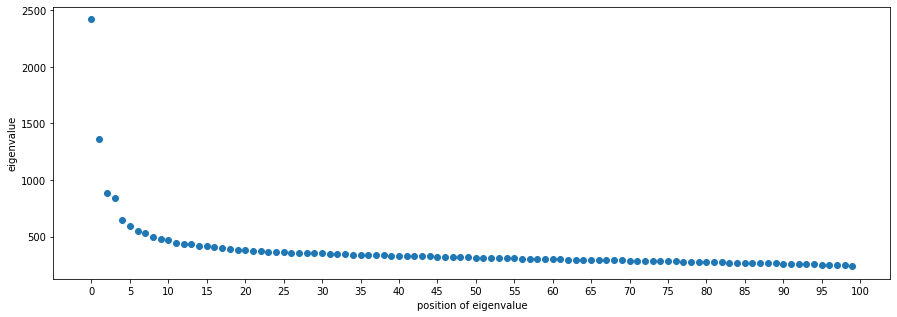

In [195]:
plt.figure(figsize=[15,5])
plt.scatter(range(len(eigvals)),eigvals)
plt.xticks(np.arange(0,101,5))
plt.xlabel("position of eigenvalue")
plt.ylabel('eigenvalue')
plt.show()

The rank of X is 100 since there are 100 nonzero eigenvalues. Only about four dimensions are imporant. Whikle there are many users and jokes, joke ratings can be approximated by a linear combination of a 4D basis created from multiple users.

# e) visualize

Visualize the dataset by projected the columns and rows on to the first three principal component directions.

In [388]:
d_jest = sio.loadmat('jesterdata.mat')
X = d_jest['X']

d_new = sio.loadmat('newuser.mat')
y = d_new['y']
true_y = d_new['truey']

m,n = X.shape

train_indices = np.squeeze(y!=-99)
num_train = np.count_nonzero(train_indices)

test_indices = np.logical_not(train_indices)
num_test = m - num_train

In [397]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X.T)
pcs = pca.transform(X.T)
rcnstrct = pca.inverse_transform(pcs)

In [400]:
rcnstrct.shape

(7200, 100)

In [391]:
u1,u2,u3 = U[:,0], U[:,1], U[:,3]
u1,u2,u3 = u1.reshape(-1,1),u2.reshape(-1,1),u3.reshape(-1,1)

<IPython.core.display.Javascript object>


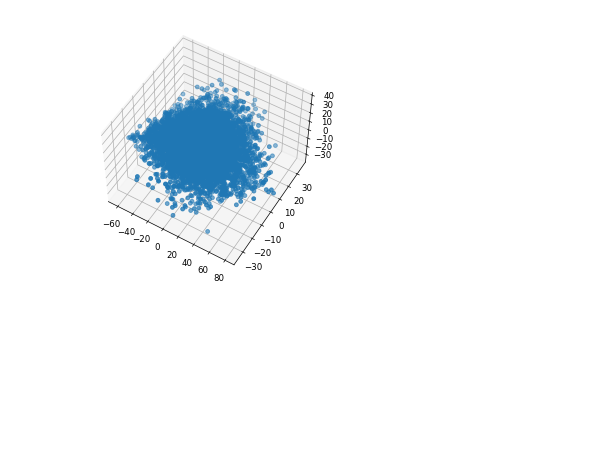

In [408]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pcs[:,0],pcs[:,1],pcs[:,2])

## f) power method

One easy way to compute the first principal compoenent for large datasets like this is the so-called power method. Let A = XX.T; then A is "diagonalizable" and the first "eigenvector" of A is the first left singular vector of X, while the first "eigenvaloue" of A is the squared first singular value of X. Write your own code to implement the power method and use it to compute the first column of U and V in the SVD of X. Does it produce the same result as the built-in svd function?

In [169]:
U, eigvals, Vt = la.svd(X)
V = Vt.T

In [197]:
A = X@X.T
# a_eigvals, a_eigvecs = la.eig(A)
b = np.random.random(A.shape[0])
for i in range(100):
    b_next = (A@b)/la.norm(A@b)
    b = b_next

In [228]:
u1 = b / la.norm(b)
sig1 = la.norm(A@u1)
eig1 = sig1**(1/2)
# np.sqrt(sig1) == eigvals[0]
v1 = u1@X / eig1

In [231]:
print("my u1 vs svd u1:", np.allclose(-u1,U[:,0]))
print("my v1 vs svd v1:",np.allclose(-v1,V[:,0]))

my u1 vs svd u1: True
my v1 vs svd v1: True


## e) power method fail

The power method is based on an intial starting vector. Give on example of a starting vector for which the power method will fail.

*The residuals of the first column of X's projection on the first left singular vector would fail, since the residuals are orthogonal.*

In [169]:
U, eigvals, Vt = la.svd(X)
V = Vt.T

In [280]:
u1 = u1.reshape(-1,1)

In [289]:
u1_resid = X - u1@u1.T@X
u1_resid = u1_resid[:,0]

In [290]:
A = X@X.T
# a_eigvals, a_eigvecs = la.eig(A)
# b = np.random.random(A.shape[0])
b = u1_resid
for i in range(100):
    b_next = (A@b)/la.norm(A@b)
    b = b_next

In [291]:
u1 = b / la.norm(b)
sig1 = la.norm(A@u1)
eig1 = sig1**(1/2)
# np.sqrt(sig1) == eigvals[0]
v1 = u1@X / eig1

In [292]:
print("my u1 vs svd u1:", np.allclose(-u1,U[:,0]))
print("my v1 vs svd v1:",np.allclose(-v1,V[:,0]))

my u1 vs svd u1: False
my v1 vs svd v1: False


# De-blurring

Many sensing and imaging systems produce signals that may be slightloy distorted or blurred (e.g. an out of focus camera). In such situations, algorithms are needed to deblur the data to obtain a more accurate estimate of the true signal. The blurring function generates a random signal and a blurred and noisy version of it, similar to the example shown below. The code simulates y = Xw + e, where y is the blurred and noisy signal, X is a matrix that performs the blurring operation, w is the true signal, and e is a vector of errors/noise. The goal is the estimate w using y and X.

In [2]:
def blurring(k = 30, sigma = 0.1, show = True):
    ## deblurring

    n = 500
    k = k
    sigma = sigma

    # generate random piecewise constant signal
    w = np.zeros((n, 1))
    w[0] = np.random.standard_normal()
    for i in range(1, n):
        if np.random.rand(1) < 0.95:
            w[i] = w[i-1]
        else:
            w[i] = np.random.standard_normal()


    # generate k-point averaging function
    h = np.ones(k) / k

    # make a matrix for blurring
    m = n + k - 1
    X = np.zeros((m, m))
    for i in range(m):
        if i < k:
            X[i, :i+1] = h[:i+1]
        else:
            X[i, i - k: i] = h

    X = X[:, 0:n]

    # blurred signal + noise
    y = np.dot(X, w) + sigma*np.random.standard_normal(size=(m, 1))
    
    if show:
        # plot
        f, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('signal')
        ax1.plot(w)
        ax2.set_title('blurred and noisy version')
        ax2.plot(y[0:n])

        plt.show()
    return X, w, y

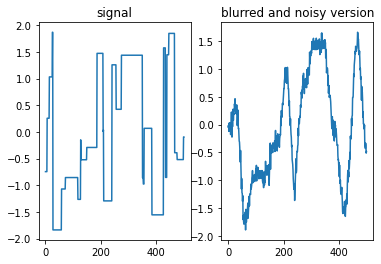

In [3]:
X, w, y = blurring()

## a) LS, truncated SVD, ridge

Implement the standard least squares, truncated SVD, and regularized least squares (i.e. ridge regression) methods for this problem.

#### LS

In [4]:
w_ls = la.inv(X.T@X)@X.T@y

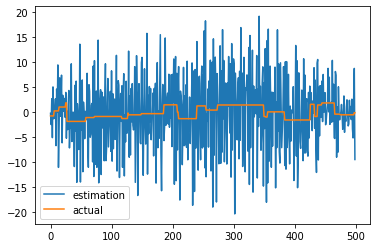

In [5]:
plt.plot(w_ls)
plt.plot(w)
plt.legend(['estimation','actual'])

plt.show()

### trunc SVD

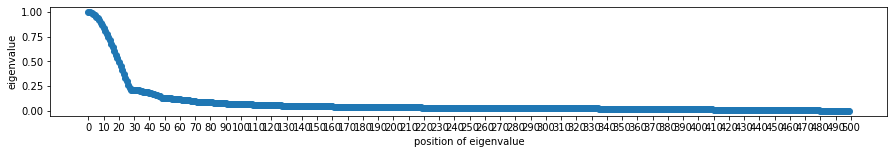

In [6]:
eigvals = la.svd(X)[1]
plt.figure(figsize=[15,2])
plt.scatter(range(len(eigvals)),eigvals)
plt.xlabel("position of eigenvalue")
plt.xticks(np.arange(0,501,10))
plt.ylabel('eigenvalue')
plt.show()

In [9]:
U, SIGx, V = prep_svd(X,pinv = True)
Uk, SIGxk, Vk = trunc_k(U, SIGx, V, 22)
w_truncsvd = get_w_hat(Uk, SIGxk, Vk, y, pinv=True)

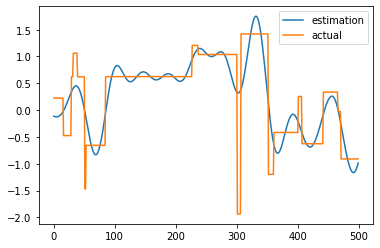

In [289]:
plt.plot(w_truncsvd)
plt.plot(w)
plt.legend(['estimation','actual'])

plt.show()

### ridge

In [290]:
len(X)*0.8

423.20000000000005

In [281]:
param_err_ridge = []
lambda_vals = np.array([0,0.00001,0.0001,0.001,0.01,0.1,0.5,1,2,4,8,16])
for lam in lambda_vals:
#     alpha = (X@X.T + lam*np.identity(X.shape[0]))
    alpha = (X@X.T + np.diag([lam]*X.shape[0]))@y
    w_ridge = X.T@alpha
    param_err_ridge.append(((w_ridge - w)**2).mean())

In [292]:
lambda_vals[np.argmin(param_err_ridge)]

0.1

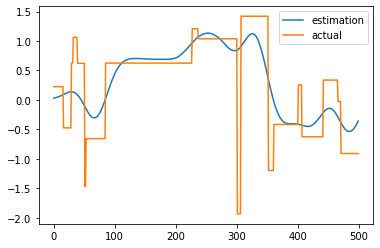

In [293]:
lam = lambda_vals[np.argmin(param_err_ridge)]
alpha = (X@X.T + np.diag([lam]*X.shape[0]))@y
w_ridge = X.T@alpha
param_err_ridge.append(((w_ridge - w)**2).mean())

plt.plot(w_ridge)
plt.plot(w)
plt.legend(['estimation','actual'])

plt.show()

## b) different averaging functions

Experiment with different averaging functions (i.e. different values of k in the blurring code) and with different noise levels (sigma in the blurring code).

In [17]:
df = pd.DataFrame(columns = ['k','sigma','best_lam','best_lam_position'])

for k in np.arange(10,101,5):
    for sigma in np.array([0.01,0.1,0.5,1,2,4,8]):
        X,w,y = blurring(k=k, sigma = sigma, show = False)
        param_err_ridge = []
        lambda_vals = np.array([0,0.001,0.01,0.1,0.5,1,2,4,8,16])
        for lam in lambda_vals:
        #     alpha = (X@X.T + lam*np.identity(X.shape[0]))
            alpha = (X@X.T + np.diag([lam]*X.shape[0]))@y
            w_ridge = X.T@alpha
            param_err_ridge.append(((w_ridge - w)**2).mean())
        best_lam_position = np.argmin(param_err_ridge)
        best_lam = lambda_vals[best_lam_position]
        df.loc[len(df)] = [k,sigma,best_lam, best_lam_position]

In [18]:
import altair as alt
alt.Chart(df).mark_line(point=alt.OverlayMarkDef()).encode(
    alt.X('k'),
    alt.Y('best_lam'),
    color=alt.Color('sigma:O')
)

C:\Users\grace\anaconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [19]:
df_trunc = pd.DataFrame(columns = ['k','sigma','best_trunc','best_trunc_position'])

for k in np.arange(10,101,5):
    for sigma in np.array([0.01,0.1,0.5,1,2,4,8]):
        X,w,y = blurring(k=k, sigma = sigma, show = False)
        param_err_trunc = []
        trunc_vals = np.arange(10,26,5)
        for t in trunc_vals:
            U, SIGx, V = prep_svd(X,pinv = True)
            Uk, SIGxk, Vk = trunc_k(U, SIGx, V, t)
            w_trunc = get_w_hat(Uk, SIGxk, Vk, y, pinv=True)
            param_err_trunc.append(((w_trunc - w)**2).mean())
        best_trunc_position = np.argmin(param_err_trunc)
        best_trunc = trunc_vals[best_trunc_position]
        df_trunc.loc[len(df_trunc)] = [k,sigma,best_trunc, best_trunc_position]

In [20]:
alt.Chart(df_trunc).mark_line(point=alt.OverlayMarkDef()).encode(
    alt.X('k'),
    alt.Y('best_trunc',scale=alt.Scale(zero=False)),
    color=alt.Color('sigma:O')
)

C:\Users\grace\anaconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)